In [2]:
import torch
from torchvision import datasets, transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
batch_size = 1
test_batch_size = 1

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('dataset/', train=True, download=True, 
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,), std=(0.5,))
                              ])),
                batch_size=batch_size,
                shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('dataset/', train=False, 
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,), std=(0.5,))
                              ])),
                batch_size=test_batch_size,
                shuffle=True)

In [16]:
image, label = next(iter(train_loader))

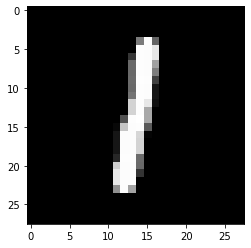

In [17]:
plt.imshow(image[0, 0, :, :], 'gray')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
# example
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [7]:
layer = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

In [11]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

In [12]:
weight = weight.detach().numpy()
weight.shape

(20, 1, 5, 5)

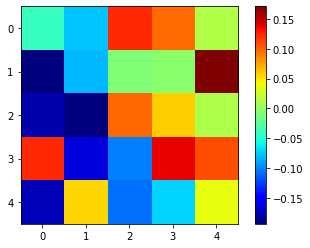

In [13]:
plt.imshow(weight[0, 0, :, :], 'jet')
plt.colorbar()
plt.show()

In [18]:
output_data = layer(image)

In [20]:
output_data = output_data.data

In [21]:
output = output_data.numpy()

In [22]:
output.shape

(1, 20, 24, 24)

In [23]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

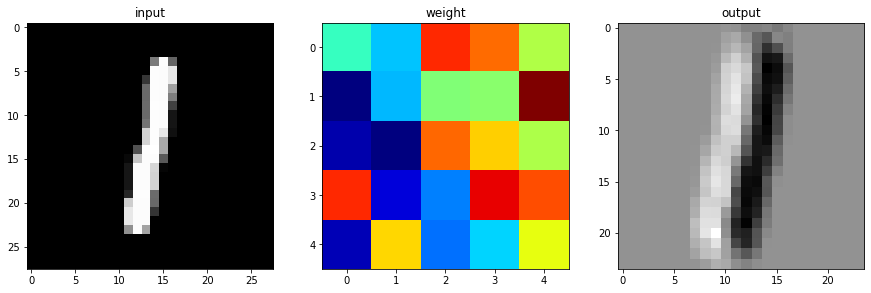

In [25]:
plt.figure(figsize=(15, 30))
plt.subplot(131)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(132)
plt.title('weight')
plt.imshow(weight[0, 0, :, :], 'jet')
plt.subplot(133)
plt.title('output')
plt.imshow(output[0, 0, :, :], 'gray')

## Pool

In [26]:
image.shape

torch.Size([1, 1, 28, 28])

In [27]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

/home/ziippy/venv_tf2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([1, 1, 14, 14])

In [29]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

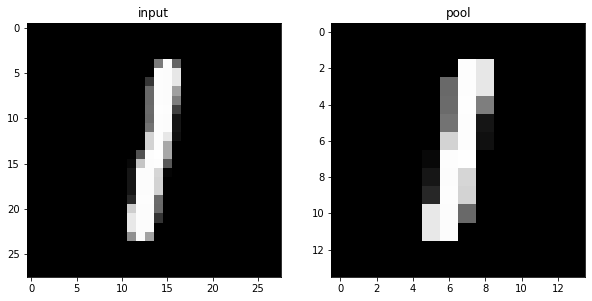

In [30]:
plt.figure(figsize=(10, 15))
plt.subplot(121)
plt.title('input')
plt.imshow(np.squeeze(image_arr), 'gray')
plt.subplot(122)
plt.title('pool')
plt.imshow(np.squeeze(pool_arr), 'gray')

## Linear

In [31]:
# using reshape or view
image.shape

torch.Size([1, 1, 28, 28])

In [33]:
flatten = image.view(1, 28*28)
flatten.shape

torch.Size([1, 784])

In [34]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [35]:
lin

tensor([[-0.1544,  0.0434, -0.2413,  0.8237, -0.0708,  0.1261,  0.1158,  0.2821,
          0.5896,  0.8216]], grad_fn=<AddmmBackward>)

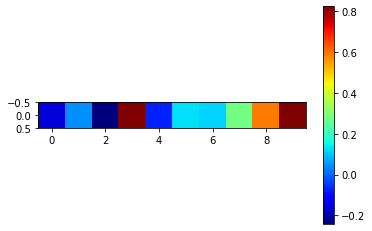

In [36]:
plt.imshow(lin.detach().numpy(), 'jet')
plt.colorbar()

## Softmax

In [38]:
with torch.no_grad():
    flatten = image.view(1, 28*28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim=1)

softmax

tensor([[0.0545, 0.0826, 0.3987, 0.0474, 0.0577, 0.0795, 0.0869, 0.0373, 0.0309,
         0.1246]])

In [39]:
np.sum(softmax.numpy())

0.99999994

## Layer class

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # feature extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        # fully-connected
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [48]:
model = Net()

In [52]:
result = model.forward(image)
result_arr = result.detach().numpy()

In [53]:
np.sum(result_arr)

-23.043503

In [54]:
np.argmax(result_arr)

9

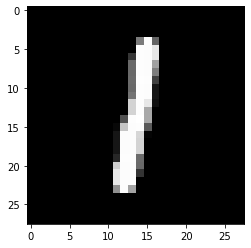

In [55]:
plt.imshow(image[0, 0, :, :], 'gray')

## Optimization

In [56]:
model = Net()

In [57]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [58]:
params = list(model.parameters())
for i in range(8):
    print(params[i].size())

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


## Before Training

In [59]:
# change to train mode
model.train()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [60]:
data, target = next(iter(train_loader))

In [61]:
data.shape, target.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [62]:
# clear
optimizer.zero_grad()

In [63]:
output = model(data)

In [64]:
loss = F.nll_loss(output, target)

In [65]:
loss.backward()

In [66]:
optimizer.step()

## Start Training

In [3]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
batch_size = 64
test_batch_size = 64

train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('dataset/', train=True, download=True, 
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,), std=(0.5,))
                              ])),
                batch_size=batch_size,
                shuffle=True)

test_loader = torch.utils.data.DataLoader(
                datasets.MNIST('dataset/', train=False, 
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,), std=(0.5,))
                              ])),
                batch_size=test_batch_size,
                shuffle=True)

/home/ziippy/venv_tf2/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # feature extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        #print(x.shape)
        # fully-connected
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
model = Net().to(device)

import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

In [9]:
epochs = 1
log_interval = 100

In [10]:
for epoch in range(1, epochs+1):
    # Train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} {}/{} ({:.0f}%)\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), 
                loss.item()))

/home/ziippy/venv_tf2/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 0/60000 (0%)	Loss: 2.289396
Train Epoch: 1 6400/60000 (11%)	Loss: 2.278761
Train Epoch: 1 12800/60000 (21%)	Loss: 2.267196
Train Epoch: 1 19200/60000 (32%)	Loss: 2.229329
Train Epoch: 1 25600/60000 (43%)	Loss: 2.201073
Train Epoch: 1 32000/60000 (53%)	Loss: 2.145969
Train Epoch: 1 38400/60000 (64%)	Loss: 2.038284
Train Epoch: 1 44800/60000 (75%)	Loss: 1.944786
Train Epoch: 1 51200/60000 (85%)	Loss: 1.807735
Train Epoch: 1 57600/60000 (96%)	Loss: 1.625918


In [13]:
for epoch in range(1, epochs+1):
    # Train mode
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} {}/{} ({:.0f}%)\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100 * batch_idx / len(train_loader), 
                loss.item()))
            
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()    
            pred = output.argmax(dim=1, keepdim=True)    
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))

Train Epoch: 1 0/60000 (0%)	Loss: 1.611014
Train Epoch: 1 6400/60000 (11%)	Loss: 1.280429
Train Epoch: 1 12800/60000 (21%)	Loss: 1.011515
Train Epoch: 1 19200/60000 (32%)	Loss: 0.874898
Train Epoch: 1 25600/60000 (43%)	Loss: 0.674588
Train Epoch: 1 32000/60000 (53%)	Loss: 0.664466
Train Epoch: 1 38400/60000 (64%)	Loss: 0.547921
Train Epoch: 1 44800/60000 (75%)	Loss: 0.451123
Train Epoch: 1 51200/60000 (85%)	Loss: 0.736964
Train Epoch: 1 57600/60000 (96%)	Loss: 0.392074

Test set: Average loss: 0.3873, Accuracy: 8997 / 10000 (90%)


## Evaluation

In [95]:
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [81]:
test_loss = 0
correct = 0

with torch.no_grad():
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    output = model(data)
    
    test_loss += F.nll_loss(output, target, reduction='sum').item()
    
    pred = output.argmax(dim=1, keepdim=True)
    
    correct += pred.eq(target.view_as(pred)).sum().item()

In [82]:
test_loss

8.21689224243164

In [83]:
pred.shape

torch.Size([64, 1])

In [86]:
target.view_as(pred).shape

torch.Size([64, 1])

In [84]:
correct

60

In [88]:
test_loss /= len(test_loader.dataset)
test_loss

8.216892242431641e-08

In [12]:
model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()    
        pred = output.argmax(dim=1, keepdim=True)    
        correct += pred.eq(target.view_as(pred)).sum().item()
        
test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)'.format(
    test_loss, correct, len(test_loader.dataset), 100 * correct / len(test_loader.dataset)))
        


Test set: Average loss: 1.5264, Accuracy: 7711 / 10000 (77%)
